In [6]:
%pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 1

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
import os
from tqdm import tqdm
import math
import re
from collections import Counter
from textwrap import wrap
import plotly.express as px
import matplotlib.pyplot as plt

## Load and Explore SQuAD Dataset
> To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
> Variable Name `HF_TOKEN`

In [13]:
# --- 1. Load Stanford SQuAD Dataset ---
print("Loading SQuAD dataset...")
# Load the SQuAD v1.1 dataset from the Hugging Face datasets library
# This will download the dataset if it's not already cached.
# Specify a revision ('1.1' or '2.0') to potentially avoid glob pattern issues
squad_dataset = load_dataset("rajpurkar/squad_v2")
print("SQuAD dataset loaded successfully.")

# --- 2. Explore SQuAD Dataset ---
print("\n--- SQuAD Dataset Structure and Examples ---")
print(f"Dataset splits: {squad_dataset.keys()}")
print(f"Number of training examples: {len(squad_dataset['train'])}")
print(f"Number of validation examples: {len(squad_dataset['validation'])}")


Loading SQuAD dataset...
SQuAD dataset loaded successfully.

--- SQuAD Dataset Structure and Examples ---
Dataset splits: dict_keys(['train', 'validation'])
Number of training examples: 130319
Number of validation examples: 11873


In [14]:
squad_dataset['train'][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [20]:
def print_squad_data(example, width=120):
    context = "\n\t".join(wrap(example['context'],width))
    question = example['question']
    answers = example['answers']
    print(f"  Context: \n\t{context}")
    print(f"  Question: {question}")
    print(f"  Answer Text: {answers['text'][0]}")
    answer_start = answers['answer_start'][0]
    answer_length = len(answers['text'][0])
    print(f"  Answer Start: {answer_start}")
    print(f"  Answer block: {example['context'][answer_start : answer_start + answer_length]}")

# Print a few examples from the training set
print("\nExample from training set:")

# Display a few examples from the training set
print("\nExample from training set:")
example = squad_dataset['train'][0]
print_squad_data(example)

# Print a few examples from the validation set
print("\nExample from validation set:")
example = squad_dataset['validation'][0]
print_squad_data(example)


Example from training set:

Example from training set:
  Context: 
	Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter,
	record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing
	competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by
	her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw
	the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide,
	earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
  Question: When did Beyonce start becoming popular?
  Answer Text: in the late 1990s
  Answer Start: 269
  Answer block: in the late 1990s

Example from validation set:
  Context: 
	The Normans (Norman: Nourmands; French: Normands

In [23]:
train_context_lengths = [ len(ex['context']) for ex in squad_dataset['train']]
val_context_lengths = [ len(ex['context']) for ex in squad_dataset['validation']]
train_num_of_answers = [ len(ex['answers']['text']) for ex in squad_dataset['train']]
val_num_of_answers = [ len(ex['answers']['text']) for ex in squad_dataset['validation']]

print(f"Average context length in training set: {np.mean(train_context_lengths)}")
print(f"Average context length in validation set: {np.mean(val_context_lengths)}")
print(f"Max context length in training set: {np.max(train_context_lengths)}")
print(f"Max context length in validation set: {np.max(val_context_lengths)}")
print(f"Min context length in training set: {np.min(train_context_lengths)}")
print(f"Min context length in validation set: {np.min(val_context_lengths)}")

print(f"Count of answers per Q in training set: {Counter(train_num_of_answers)}")
print(f"Count of answers per Q in validation set: {Counter(val_num_of_answers)}")


Average context length in training set: 754.5662873410631
Average context length in validation set: 810.9731323170219
Max context length in training set: 3706
Max context length in validation set: 4063
Min context length in training set: 151
Min context length in validation set: 169
Count of answers per Q in training set: Counter({1: 86821, 0: 43498})
Count of answers per Q in validation set: Counter({0: 5945, 3: 4238, 5: 945, 4: 625, 2: 88, 6: 31, 1: 1})


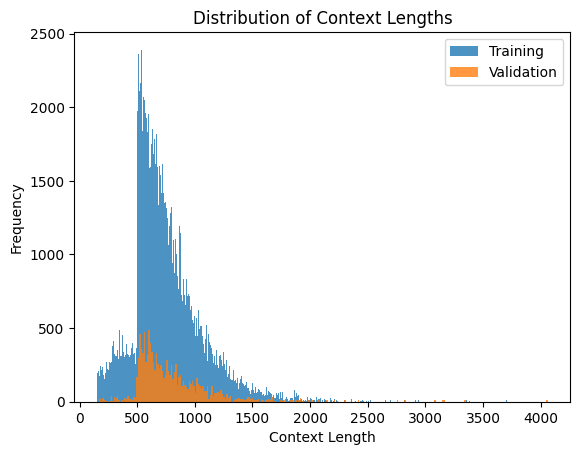

In [12]:
# pLot the context lengths
_=plt.hist(train_context_lengths, bins=500, alpha=0.8, label='Training')
_=plt.hist(val_context_lengths, bins=300, alpha=0.8, label='Validation')
plt.legend()
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.title('Distribution of Context Lengths')
plt.show()

## --- Configuration ---

In [ ]:

# Set device for training (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# GloVe embedding configuration
GLOVE_PATH = 'glove.6B/glove.6B.50d.txt' # Path to your GloVe file (e.g., glove.6B.50d.txt)
EMBEDDING_DIM = 50 # Dimension of GloVe embeddings (must match the chosen GloVe file)

# Model hyper-parameters
MAX_CONTEXT_LEN = 300 # Maximum number of tokens for context
MAX_QUESTION_LEN = 50 # Maximum number of tokens for question
HIDDEN_DIM = EMBEDDING_DIM # Hidden dimension for the transformer block
NUM_HEADS = 1 # Number of attention heads (as requested, only one)
FF_DIM = EMBEDDING_DIM * 4 # Dimension for the feed-forward network
DROPOUT_RATE = 0.1

# Training hyper-parameters
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

In [ ]:

# --- 3. Load GloVe Vectors ---
print(f"\nLoading GloVe embeddings from {GLOVE_PATH}...")
word_to_idx = {} # Dictionary to map words to their indices
idx_to_word = [] # List to map indices back to words
embeddings = [] # List to store embedding vectors

# Add a special token for padding and unknown words
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
word_to_idx[PAD_TOKEN] = 0
idx_to_word.append(PAD_TOKEN)
embeddings.append(np.zeros(EMBEDDING_DIM)) # Padding token has a zero vector

word_to_idx[UNK_TOKEN] = 1
idx_to_word.append(UNK_TOKEN)
# Initialize UNK token with a random vector or average vector (here, random)
embeddings.append(np.random.rand(EMBEDDING_DIM) * 0.01)

# Read the GloVe file
try:
    with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Reading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == EMBEDDING_DIM: # Ensure vector dimension matches
                word_to_idx[word] = len(word_to_idx)
                idx_to_word.append(word)
                embeddings.append(vector)
    # Convert the list of embeddings to a numpy array
    embeddings_matrix = np.array(embeddings, dtype='float32')
    # Convert to a PyTorch tensor
    pretrained_embeddings = torch.from_numpy(embeddings_matrix).to(DEVICE)
    print(f"Loaded {len(word_to_idx)} GloVe embeddings of dimension {EMBEDDING_DIM}.")
except FileNotFoundError:
    print(f"Error: GloVe file not found at {GLOVE_PATH}. Please download it and place it correctly.")
    print("You can download GloVe from: https://nlp.stanford.edu/projects/glove/")
    print("For example, download 'glove.6B.zip', extract it, and place 'glove.6B.50d.txt' in the same directory as this script, or update GLOVE_PATH.")
    exit() # Exit if GloVe file is not found

# --- Helper function for tokenization and indexing ---
# Simple word tokenizer (can be replaced with NLTK or spaCy for better tokenization)
def simple_tokenize(text):
    # Convert to lowercase, remove punctuation except apostrophes, split by space
    text = text.lower()
    text = re.sub(r"[^a-z0-9']+", " ", text) # Keep letters, numbers, apostrophes
    tokens = text.split()
    return tokens

# Function to convert tokens to indices
def tokens_to_indices(tokens, word_to_idx, max_len, unk_idx=1, pad_idx=0):
    indices = [word_to_idx.get(token, unk_idx) for token in tokens]
    # Pad or truncate
    if len(indices) < max_len:
        indices.extend([pad_idx] * (max_len - len(indices)))
    else:
        indices = indices[:max_len]
    return indices

# Function to find answer start and end token indices
def find_answer_token_indices(context_tokens, answer_text, answer_start_char, context_original):
    # This is a simplified approach and might not be perfect for all cases
    # A more robust approach would involve character-level mapping or spaCy's tokenization

    # Reconstruct context from tokens to find character offsets
    # This is crucial because simple_tokenize changes character offsets
    current_char_offset = 0
    token_char_map = [] # List of (start_char, end_char) for each token
    for token in context_tokens:
        # Find the token in the original context (case-insensitive)
        # This is a heuristic and might fail if tokens are not unique or context is complex
        match = re.search(re.escape(token), context_original[current_char_offset:], re.IGNORECASE)
        if match:
            token_start_char = current_char_offset + match.start()
            token_end_char = current_char_offset + match.end()
            token_char_map.append((token_start_char, token_end_char))
            current_char_offset = token_end_char # Move cursor past this token
        else:
            # If token not found, assume it's a special character or complex case
            # For simplicity, we'll just advance the offset by token length + 1 (for space)
            # A more robust solution would re-align with original text
            token_char_map.append((current_char_offset, current_char_offset + len(token)))
            current_char_offset += len(token) + 1 # +1 for potential space

    # Find the start and end token indices
    start_token_idx = -1
    end_token_idx = -1 # Inclusive end index

    for i, (token_start_char, token_end_char) in enumerate(token_char_map):
        # Check if the answer starts within or at the beginning of this token
        if answer_start_char >= token_start_char and answer_start_char < token_end_char:
            start_token_idx = i
            break

    # If start token found, find the end token
    if start_token_idx != -1:
        # Calculate the end character of the answer in the original context
        answer_end_char = answer_start_char + len(answer_text)

        for i in range(start_token_idx, len(token_char_map)):
            token_start_char, token_end_char = token_char_map[i]
            # If the answer ends within or at the end of this token
            if answer_end_char <= token_end_char:
                end_token_idx = i
                break
            # If the answer extends beyond this token, continue searching
            elif answer_end_char > token_end_char and i == len(token_char_map) - 1:
                # If it's the last token and answer still extends, set end to last token
                end_token_idx = i
                break

    # If answer not found or indices are invalid, set to 0 (padding token)
    if start_token_idx == -1 or end_token_idx == -1:
        start_token_idx = 0
        end_token_idx = 0

    # Ensure indices are within MAX_CONTEXT_LEN
    start_token_idx = min(start_token_idx, MAX_CONTEXT_LEN - 1)
    end_token_idx = min(end_token_idx, MAX_CONTEXT_LEN - 1)

    # Ensure start_token_idx <= end_token_idx
    if start_token_idx > end_token_idx:
        start_token_idx = end_token_idx

    return start_token_idx, end_token_idx


# --- Custom SQuAD Dataset Class ---
class SQuADDataset(Dataset):
    def __init__(self, dataset_split, word_to_idx, max_context_len, max_question_len):
        self.dataset = dataset_split
        self.word_to_idx = word_to_idx
        self.max_context_len = max_context_len
        self.max_question_len = max_question_len
        self.unk_idx = word_to_idx[UNK_TOKEN]
        self.pad_idx = word_to_idx[PAD_TOKEN]

        self.processed_data = []
        print(f"Processing {len(self.dataset)} examples...")
        for example in tqdm(self.dataset, desc="Preprocessing SQuAD"):
            context = example['context']
            question = example['question']
            answer_text = example['answers']['text'][0]
            answer_start_char = example['answers']['answer_start'][0]

            # Tokenize context and question
            context_tokens = simple_tokenize(context)
            question_tokens = simple_tokenize(question)

            # Convert tokens to indices and pad/truncate
            context_indices = tokens_to_indices(context_tokens, self.word_to_idx, self.max_context_len, self.unk_idx, self.pad_idx)
            question_indices = tokens_to_indices(question_tokens, self.word_to_idx, self.max_question_len, self.unk_idx, self.pad_idx)

            # Find answer token indices
            start_token_idx, end_token_idx = find_answer_token_indices(context_tokens, answer_text, answer_start_char, context)

            self.processed_data.append({
                'context_indices': torch.tensor(context_indices, dtype=torch.long),
                'question_indices': torch.tensor(question_indices, dtype=torch.long),
                'start_token_idx': torch.tensor(start_token_idx, dtype=torch.long),
                'end_token_idx': torch.tensor(end_token_idx, dtype=torch.long)
            })

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]

# Create dataset instances
train_dataset = SQuADDataset(squad_dataset['train'], word_to_idx, MAX_CONTEXT_LEN, MAX_QUESTION_LEN)
val_dataset = SQuADDataset(squad_dataset['validation'], word_to_idx, MAX_CONTEXT_LEN, MAX_QUESTION_LEN)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Train loader has {len(train_loader)} batches.")
print(f"Validation loader has {len(val_loader)} batches.")


# --- 4. Create Extractive QA Model ---

# Sinusoidal Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe) # Register as buffer so it's not a model parameter

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        # Add positional encoding to the input
        return x + self.pe[:x.size(0), :]


# Single Self-Attention Head
class SelfAttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super(SelfAttentionHead, self).__init__()
        # Linear transformations for Query, Key, Value
        self.query_proj = nn.Linear(embed_dim, head_dim)
        self.key_proj = nn.Linear(embed_dim, head_dim)
        self.value_proj = nn.Linear(embed_dim, head_dim)
        self.scale = head_dim ** -0.5 # Scaling factor for dot product attention

    def forward(self, query, key, value, mask=None):
        # Project inputs to query, key, value space
        Q = self.query_proj(query)
        K = self.key_proj(key)
        V = self.value_proj(value)

        # Calculate attention scores (Q * K^T)
        # Q: (batch_size, seq_len, head_dim)
        # K.transpose(-2, -1): (batch_size, head_dim, seq_len)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        # Apply mask if provided (for padding tokens)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention probabilities
        attention_probs = torch.softmax(attention_scores, dim=-1)

        # Multiply attention probabilities with Value to get weighted sum
        # attention_probs: (batch_size, seq_len, seq_len)
        # V: (batch_size, seq_len, head_dim)
        output = torch.matmul(attention_probs, V) # (batch_size, seq_len, head_dim)
        return output


# Simple Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        # For simplicity, we're using a single SelfAttentionHead directly
        # In a full MultiHeadAttention, we'd have multiple heads and then concatenate
        # Here, num_heads is fixed to 1, so head_dim == embed_dim
        assert num_heads == 1, "This TransformerBlock is designed for a single attention head."
        self.attention_head = SelfAttentionHead(embed_dim, embed_dim) # head_dim = embed_dim for single head

        # Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len, embed_dim)

        # Self-attention part
        # Apply attention, then dropout, then add residual connection, then layer norm
        attn_output = self.attention_head(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward part
        # Apply feed-forward, then dropout, then add residual connection, then layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x


# Extractive QA Model
class ExtractiveQAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_heads, ff_dim, dropout_rate, pretrained_embeddings=None):
        super(ExtractiveQAModel, self).__init__()
        # Embedding layer
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embedding_dim)

        # Transformer Block (single block as requested)
        self.transformer_block = TransformerBlock(hidden_dim, num_heads, ff_dim, dropout_rate)

        # Output layers for predicting start and end token probabilities
        # These layers will take the transformer output for the context and project it
        # to a single logit for each token, representing its likelihood as start/end
        self.start_head = nn.Linear(hidden_dim, 1)
        self.end_head = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, context_indices, question_indices):
        # context_indices shape: (batch_size, max_context_len)
        # question_indices shape: (batch_size, max_question_len)

        # Get embeddings for context and question
        context_embed = self.embedding(context_indices) # (batch_size, max_context_len, embedding_dim)
        question_embed = self.embedding(question_indices) # (batch_size, max_question_len, embedding_dim)

        # Apply positional encoding
        # Transpose for PositionalEncoding: (seq_len, batch_size, embed_dim)
        context_embed_pe = self.pos_encoder(context_embed.transpose(0, 1)).transpose(0, 1)
        question_embed_pe = self.pos_encoder(question_embed.transpose(0, 1)).transpose(0, 1)

        # Dropout after positional encoding
        context_embed_pe = self.dropout(context_embed_pe)
        question_embed_pe = self.dropout(question_embed_pe)

        # Concatenate context and question embeddings
        # A common approach in QA models is to process context and question together
        # For simplicity, we'll process context independently and use question for attention
        # A more advanced model would use cross-attention between context and question.
        # Here, we'll just use context for the transformer block and assume the question
        # has implicitly influenced the context representation through shared embeddings
        # or a more complex interaction layer (which this simple model lacks).
        # For a truly simple single-block model, we'll just run the transformer on the context.
        # The question's role is primarily to guide the loss function during training.

        # Create attention mask for context padding
        # mask shape: (batch_size, 1, 1, max_context_len) for broadcasting
        context_mask = (context_indices != 0).unsqueeze(1).unsqueeze(1) # 0 is PAD_TOKEN index

        # Pass context embeddings through the transformer block
        transformer_output = self.transformer_block(context_embed_pe, mask=context_mask)
        # transformer_output shape: (batch_size, max_context_len, hidden_dim)

        # Predict start and end logits
        start_logits = self.start_head(transformer_output).squeeze(-1) # (batch_size, max_context_len)
        end_logits = self.end_head(transformer_output).squeeze(-1)   # (batch_size, max_context_len)

        # Apply mask to logits to prevent predicting padding tokens
        # Set logits of padding tokens to a very small number so they get 0 probability after softmax
        start_logits = start_logits.masked_fill(context_indices == 0, float('-inf'))
        end_logits = end_logits.masked_fill(context_indices == 0, float('-inf'))

        return start_logits, end_logits


# Initialize the model
model = ExtractiveQAModel(
    vocab_size=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    dropout_rate=DROPOUT_RATE,
    pretrained_embeddings=pretrained_embeddings
).to(DEVICE)

print("\n--- Model Architecture ---")
print(model)

# --- 5. Train and Evaluate the Model ---

# Loss function: CrossEntropyLoss for start and end predictions
# We treat this as a classification problem where each token in the context
# has a probability of being the start/end of the answer.
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode
    total_train_loss = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        context_indices = batch['context_indices'].to(DEVICE)
        question_indices = batch['question_indices'].to(DEVICE)
        start_labels = batch['start_token_idx'].to(DEVICE)
        end_labels = batch['end_token_idx'].to(DEVICE)

        optimizer.zero_grad() # Clear gradients

        # Forward pass
        start_logits, end_logits = model(context_indices, question_indices)

        # Calculate loss for start and end predictions
        start_loss = criterion(start_logits, start_labels)
        end_loss = criterion(end_logits, end_labels)
        loss = start_loss + end_loss # Total loss is sum of start and end losses

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    # --- Evaluation ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    correct_start_predictions = 0
    correct_end_predictions = 0
    total_predictions = 0

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for batch_idx, batch in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")):
            context_indices = batch['context_indices'].to(DEVICE)
            question_indices = batch['question_indices'].to(DEVICE)
            start_labels = batch['start_token_idx'].to(DEVICE)
            end_labels = batch['end_token_idx'].to(DEVICE)

            start_logits, end_logits = model(context_indices, question_indices)

            # Calculate loss
            start_loss = criterion(start_logits, start_labels)
            end_loss = criterion(end_logits, end_labels)
            loss = start_loss + end_loss
            total_val_loss += loss.item()

            # Calculate simple accuracy for start/end token predictions
            # Get the predicted start/end token index by finding the argmax of logits
            predicted_start = torch.argmax(start_logits, dim=1)
            predicted_end = torch.argmax(end_logits, dim=1)

            correct_start_predictions += (predicted_start == start_labels).sum().item()
            correct_end_predictions += (predicted_end == end_labels).sum().item()
            total_predictions += start_labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    start_accuracy = correct_start_predictions / total_predictions
    end_accuracy = correct_end_predictions / total_predictions

    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | "
          f"Start Token Accuracy: {start_accuracy:.4f} | "
          f"End Token Accuracy: {end_accuracy:.4f}")

print("\n--- Training Complete ---")

# --- Example Usage (Inference) ---
print("\n--- Example Inference ---")

# Pick an example from the validation set
inference_example = squad_dataset['validation'][10] # Using a different example
original_context = inference_example['context']
original_question = inference_example['question']
original_answer_text = inference_example['answers']['text'][0]

print(f"Original Context: {original_context}")
print(f"Original Question: {original_question}")
print(f"Original Answer: {original_answer_text}")

# Preprocess for inference
context_tokens_inf = simple_tokenize(original_context)
question_tokens_inf = simple_tokenize(original_question)

context_indices_inf = tokens_to_indices(context_tokens_inf, word_to_idx, MAX_CONTEXT_LEN, unk_idx=1, pad_idx=0)
question_indices_inf = tokens_to_indices(question_tokens_inf, word_to_idx, MAX_QUESTION_LEN, unk_idx=1, pad_idx=0)

# Convert to tensors and add batch dimension
context_tensor_inf = torch.tensor(context_indices_inf, dtype=torch.long).unsqueeze(0).to(DEVICE)
question_tensor_inf = torch.tensor(question_indices_inf, dtype=torch.long).unsqueeze(0).to(DEVICE)

model.eval() # Set model to evaluation mode
with torch.no_grad():
    start_logits_inf, end_logits_inf = model(context_tensor_inf, question_tensor_inf)

# Get predicted start and end indices
predicted_start_idx = torch.argmax(start_logits_inf, dim=1).item()
predicted_end_idx = torch.argmax(end_logits_inf, dim=1).item()

# Ensure predicted_start_idx <= predicted_end_idx
if predicted_start_idx > predicted_end_idx:
    predicted_start_idx, predicted_end_idx = predicted_end_idx, predicted_start_idx

print(f"Predicted Start Token Index: {predicted_start_idx}")
print(f"Predicted End Token Index: {predicted_end_idx}")

# Reconstruct the answer from tokens
predicted_answer_tokens = context_tokens_inf[predicted_start_idx : predicted_end_idx + 1]
predicted_answer = " ".join(predicted_answer_tokens)

print(f"Predicted Answer: {predicted_answer}")
print(f"Actual Answer: {original_answer_text}")

# Note on evaluation metrics:
# For a full SQuAD evaluation, one would typically calculate Exact Match (EM) and F1 score.
# This requires more sophisticated post-processing of predictions (e.g., handling cases
# where predicted start > predicted end, or ensuring the predicted span is valid).
# For this simple example, we focused on token-level accuracy and loss.
